# Εργασία 2 (Τεχνικές Εξόρυξης Δεδομένων)
## Data Mining: Assignment 2
***
### Μαρία Φριτζελά 1115201400218
***

In [1]:
import glob
import csv
import re
import pandas as pd
import numpy as np
from itertools import chain
from IPython.core.display import display
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import  svm, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

Κατηγοριοποίηση δεδομένων κειμένου από ειδησιογραφικά άρθρα 5 κατηγοριών:</br>
Classifying text data from articles of 5 different categories:

In [2]:
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

### Get names of files for testing and training
Data set consists of 2225 documents from a news website
corresponding to stories in five topical areas from 2004-2005.</br>
</br>
80% of data points (files) will be used for training, the remaining 20% will be used for testing.</br>
We will be collecting the files names as elements in two lists (one for each purpose)

In [3]:
files_path = 'fulltext/data/'
train_files = []    # list of files names that will be used for training
test_files = []     # list of files names that will be used for testing

for category in categories:
    # get all txt files names from current category
    files = glob.glob(files_path+category+'/*.txt')
    # sort them alphabetically
    files.sort()
    # separate list so that first 80% will be copied into the train_files list
    sep_index = round(len(files) * 0.8)
    train_files.extend(files[:sep_index])
    test_files.extend(files[sep_index:])

Result:

In [4]:
print("Total files: 2225")
print("# of train files: "+str(len(train_files)))
print("# of test files: "+str(len(test_files)))

Total files: 2225
# of train files: 1781
# of test files: 444


### Create file train_set.tsv
Columns: id, title, content, category <br>
_The id is the name of the text file with the first letter of the category prepended (ex. "b001")_

In [5]:
with open('train_set.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content', 'category'])
    # write rows for all other files
    for file_path in train_files:
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content),
                                 cat])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")


UnicodeDecodeError for file: fulltext/data/sport/199.txt. File skipped


### Create file test_set.tsv
Columns: id, title, content

In [6]:
with open('test_set.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content'])
    # write rows for all other files
    for file_path in test_files:
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content)])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")

### Create a file with the full dataset: dataset.tsv


In [7]:
with open('dataset.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content', 'category'])
    # write rows for all other files
    for file_path in chain(train_files, test_files):
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content),
                                 cat])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")

UnicodeDecodeError for file: fulltext/data/sport/199.txt. File skipped


Create a DataFrame for the data_set (id column as the index)

In [8]:
#testdf = pd.read_csv("test_set.tsv", sep='\t', index_col='id')
#traindf = pd.read_csv("train_set.tsv", sep='\t', index_col='id')
datadf = pd.read_csv("dataset.tsv", sep='\t', index_col='id')
datadf

,title,content,category
id,,,
b001,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,business
b002,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,business
b003,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,business
b004,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,business
b005,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,business
...,...,...,...
t397,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,tech
t398,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,tech
t399,Be careful how you code,A new European directive could put software wr...,tech


## 1 Δημιουργία WordCloud
**Create a WordCloud for the articles of each category**

In [9]:
# Create our own stopWord list:
stopwords = set(STOPWORDS)
stopwords.update(['say', 'said', 'saying', 'will', 'many', 'new', 'people', 'now', 'one'])

### Business

In [10]:
#create wordcloud
# select rows where the id contains 'b' (=business) using filter
wordcloud_business = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(" ".join(title+' '+content
                                             for title, content in datadf.filter(like='b', axis=0)
                                                                   [['title', 'content']].values.tolist()))

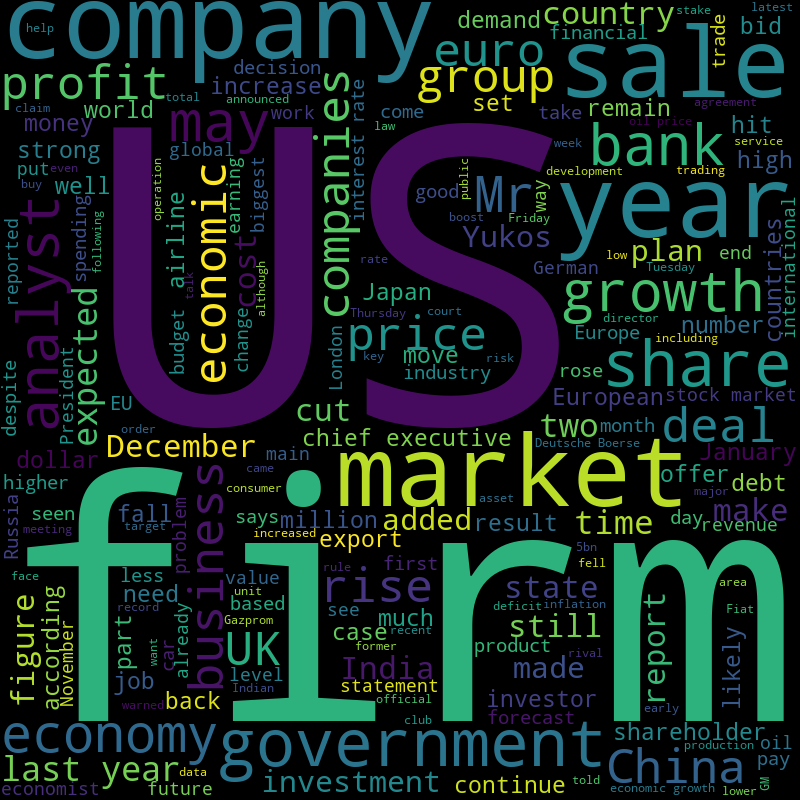

In [11]:
business_image = wordcloud_business.to_image()
display(business_image)

### Entertainment

In [12]:
wordcloud_entertainment = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='e', axis=0)[['title', 'content']].values))

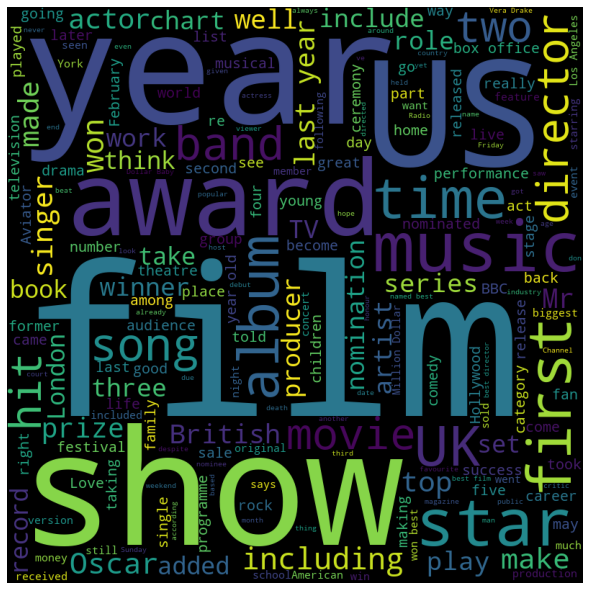

In [13]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_entertainment)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Politics

In [14]:
wordcloud_politics = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='p', axis=0)[['title', 'content']].values))

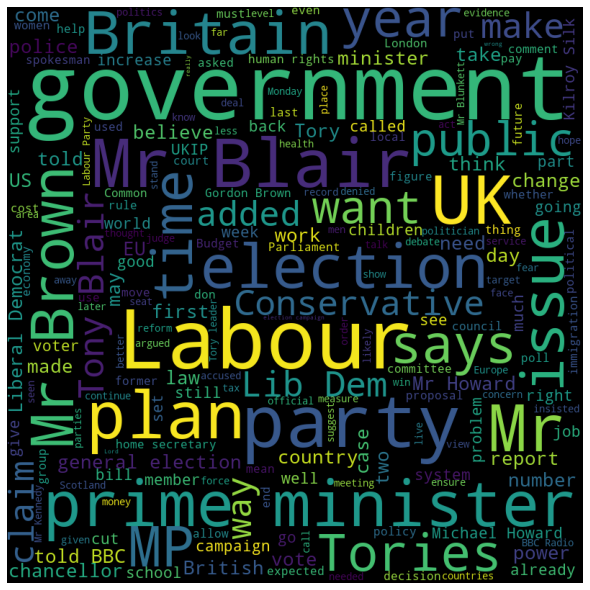

In [15]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_politics)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Sport

In [16]:
wordcloud_sport = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='s', axis=0)[['title', 'content']].values))

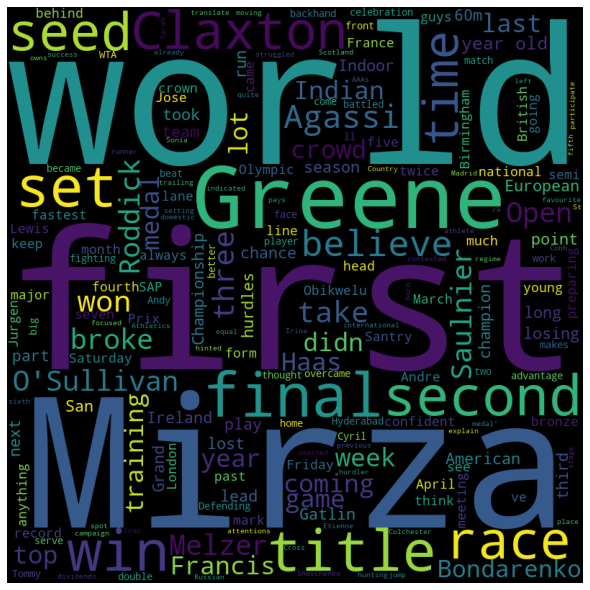

In [17]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_sport)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Tech

In [ ]:
wordcloud_tech = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(datadf.filter(like='t', axis=0)[['title', 'content']].values))

In [ ]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_tech)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## 2 Υλοποίηση Κατηγοριοποίησης (Classification)
**Data Classification**

### A) Cleaning and Pre-processing the data
Create a Pandas Series, adding it as a new row into the datadf,
by concatenating the title and content column of the datadf <br>
Clean up text:<br>
- Add a space before performing the sum to not connect words together accidentally
- Make all the words lower case to facilitate clean up, using `.lower`
- Remove our list of stopwords
- Remove punctuation and special characters using `re.sub`
- Remove all words containing digits, and any digits using `re.sub`.

In [ ]:
datadf['text'] = datadf[['title', 'content']]\
    .apply(lambda row: ' '.join(row.values.astype(str)), axis=1)\
    .apply(lambda item: list(filter(lambda word: word not in stopwords, item.lower().split())))\
    .apply(lambda item: re.sub('[^A-Za-z0-9 ]+', '', ' '.join(item)))\
    .apply(lambda item: re.sub(r'\w*\d\w*', '', item))


Seperate data into train (80%) and test (20%) set <br>
Use the stratify parameter to ensure that the split between the different categories is done equally

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datadf.text, datadf.category,
                                                                test_size=0.2, stratify=datadf.category)

#### Bag-of-words
Create bag-of-words vector

In [ ]:
bow_vectorizer = CountVectorizer(max_features=3000, stop_words='english')

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


In [ ]:
pd.DataFrame(X_train_bow[0:1].T.todense(), index=bow_vectorizer.get_feature_names(), columns=["counts"])\
.sort_values(by=["counts"],ascending=False)

In [ ]:
pd.DataFrame(X_test_bow[0:1].T.todense(), index=bow_vectorizer.get_feature_names(), columns=["counts"])\
.sort_values(by=["counts"],ascending=False)

#### TF-IDF

In [ ]:
tfidf_vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=3000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
pd.DataFrame(X_train_tfidf[0:1].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])\
.sort_values(by=["tfidf"],ascending=False)

Create a function for plotting out ROC Curves for our multiclasses

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

def ROC_Plot(X_train, X_test, y_train, y_test, model=svm.SVC(kernel='linear')):
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=['business', 'entertainment', 
                                               'politics', 'sport', 'tech'])
    y_test_bin = label_binarize(y_test, classes=['business', 'entertainment', 
                                               'politics', 'sport', 'tech'])
    n_classes = y_train_bin.shape[1]
    
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train_bin).decision_function(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot all ROC curves
    plt.figure()
    lw = 2
    colors = ['red', 'blue', 'aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()  

### B) Classification

#### Support Vector Machines (SVM)
*Bag of Words*


In [ ]:
#instantiate the model
svm_clf = svm.SVC()

# train the model on the BoW training set
svm_clf.fit(X_train_bow, y_train)
# predict the BoW test set
y_pred_svm_bow = svm_clf.predict(X_test_bow)

In [ ]:
print("10-fold Cross Validation Precision SVM for BoW:",
      np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall SVM for BoW:",
      np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure SVM for BoW:",
     np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy SVM for BoW:",
      np.mean(cross_val_score(svm_clf, X_train_bow, y_train, cv=10, scoring='accuracy')))

ROC Plot for SVM with BoW

In [ ]:
ROC_Plot(X_train_bow, X_test_bow, y_train, y_test)

*TF/IDF*

In [ ]:
# train the model on the TF/IDF training set (previous weights and variables are reset)
svm_clf.fit(X_train_tfidf, y_train)
# predict the TF/IDF test set
y_pred_svm_tfidf = svm_clf.predict(X_test_tfidf)

In [ ]:
print("10-fold Cross Validation Precision SVM for TF/IDF:",
      np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall SVM for TF/IDF:",
      np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure SVM for TF/IDF:",
     np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy SVM for TF/IDF:",
      np.mean(cross_val_score(svm_clf, X_train_tfidf, y_train, cv=10, scoring='accuracy')))

#### Random Forest
*Bag of Words*

In [ ]:
# Instantiate the model
rf = RandomForestClassifier()

# Train the model on the BoW training set
rf.fit(X_train_bow, y_train)
# predict the BoW test set
y_pred_rf_bow = rf.predict(X_test_bow)

In [ ]:
print("10-fold Cross Validation Precision RF for BoW:",
      np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall RF for BoW:",
      np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure RF for BoW:",
     np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy RF for BoW:",
      np.mean(cross_val_score(rf, X_train_bow, y_train, cv=10, scoring='accuracy')))

*TF/IDF*

In [ ]:
# train the model on the TF/IDF training set (previous weights and variables are reset)
rf.fit(X_train_tfidf, y_train)
# predict the TF/IDF test set
y_pred_rf_tfidf = rf.predict(X_test_tfidf)

In [ ]:
print("10-fold Cross Validation Precision RF for TF/IDF:",
      np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall RF for TF/IDF:",
      np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure RF for TF/IDF:",
     np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy RF for TF/IDF:",
      np.mean(cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='accuracy')))

#### Naive Bayes
*Bag of Words*

In [ ]:
# Instantiate the model
nb = GaussianNB()

# Train the model on the BoW training set
nb.fit(X_train_bow.toarray(), y_train)
# predict the BoW test set
y_pred_nb_bow = nb.predict(X_test_bow.toarray())

In [ ]:
print("10-fold Cross Validation Precision NB for BoW:",
      np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall NB for BoW:",
      np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure NB for BoW:",
     np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy NB for BoW:",
      np.mean(cross_val_score(nb, X_train_bow.toarray(), y_train, cv=10, scoring='accuracy')))

*TF/IDF*

In [ ]:
# Train the model on the TF/IDF training set (previous weights and variables are reset)
nb.fit(X_train_tfidf.toarray(), y_train)
# predict the TF/IDF test set
y_pred_nb_tfidf = nb.predict(X_test_tfidf.toarray())

In [ ]:
print("10-fold Cross Validation Precision NB for TF/IDF:",
      np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='precision_macro')))
print("10-fold Cross Validation Recall NB for TF/IDF:",
      np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='recall_macro')))
print("10-fold Cross Validation F-Measure NB for TF/IDF:",
     np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='f1_macro')))
print("10-fold Cross Validation Accuracy NB for TF/IDF:",
      np.mean(cross_val_score(nb, X_train_tfidf.toarray(), y_train, cv=10, scoring='accuracy')))

#### K-Nearest Neighbor

Create the majority voting function. It returns the value that appears more often in List. If two values have the same number of appearances in the list, it returns the first element of the list.

In [ ]:
from statistics import mode, StatisticsError

def maj_voting(List): 
    try:
        return mode(List)
    except StatisticsError:
        return List[0]

We will be creating our own KNN estimator which will be scikit-learn-compatible

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KDTree

class MyKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, leaf_size=40):
        self.n_neighbors = n_neighbors
        # leaf size for the KDTree
        self.leaf_size = leaf_size

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Create the KDTree
        self._tree = KDTree(X, self.leaf_size)
        
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)

        #closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        closest_dist, closest_indices = self._tree.query(X, k=self.n_neighbors)
        return np.array(list(map(maj_voting, self.y_[closest_indices])))


Check whether estimator adheres to the scikit-learn interface and standards

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(MyKNNClassifier)

Use our custom classifier for our dataset (BoW and TF/IDF):

In [ ]:
# Instantiate the model
myclf = MyKNNClassifier(n_neighbors=2)

# Train the model on the BoW training set
myclf.fit(X_train_bow.toarray(), y_train)
# predict the BoW test set
y_pred_test_bow = myclf.predict(X_test_bow.toarray())

In [ ]:
print("Accuracy of My KNN for BoW:",metrics.accuracy_score(y_test, y_pred_test_bow))

#### Scores of Classifiers

In [ ]:
#Model Precision: what percentage was classified correctly?
print("Precision SVM for BoW:",metrics.precision_score(y_test, y_pred_svm_bow, average=None))
print("Precision SVM for TF/IDF:",metrics.precision_score(y_test, y_pred_svm_tfidf, average=None))
print("Precision RF for BoW:",metrics.precision_score(y_test, y_pred_rf_bow, average=None))
print("Precision RF for TF/IDF:",metrics.precision_score(y_test, y_pred_rf_tfidf, average=None))
print("Precision NB for BoW:",metrics.precision_score(y_test, y_pred_nb_bow, average=None))
print("Precision NB for TF/IDF:",metrics.precision_score(y_test, y_pred_nb_tfidf, average=None))

print()
# Model Recall
print("Recall SVM for BoW:",metrics.recall_score(y_test, y_pred_svm_bow, average=None))
print("Recall SVM for TF/IDF:",metrics.recall_score(y_test, y_pred_svm_tfidf, average=None))
print("Recall RF for BoW:",metrics.recall_score(y_test, y_pred_rf_bow, average=None))
print("Recall RF for TF/IDF:",metrics.recall_score(y_test, y_pred_rf_tfidf, average=None))
print("Recall NB for BoW:",metrics.recall_score(y_test, y_pred_nb_bow, average=None))
print("Recall NB for TF/IDF:",metrics.recall_score(y_test, y_pred_nb_tfidf, average=None))

print()
# F-Measure
print("F-Measure SVM for BoW:", metrics.f1_score(y_test, y_pred_svm_bow, average=None))
print("F-Measure SVM for TF/IDF:", metrics.f1_score(y_test, y_pred_svm_tfidf, average=None))
print("F-Measure RF for BoW:", metrics.f1_score(y_test, y_pred_rf_bow, average=None))
print("F-Measure RF for TF/IDF:", metrics.f1_score(y_test, y_pred_rf_tfidf, average=None))
print("F-Measure NB for BoW:", metrics.f1_score(y_test, y_pred_nb_bow, average=None))
print("F-Measure NB for TF/IDF:", metrics.f1_score(y_test, y_pred_nb_tfidf, average=None))

print()
# compare actual response values (y_test) with predicted response values (y_pred)
print("Accuracy SVM for BoW:",metrics.accuracy_score(y_test, y_pred_svm_bow))
print("Accuracy SVM for TF/IDF:",metrics.accuracy_score(y_test, y_pred_svm_tfidf))
print("Accuracy RF for BoW:",metrics.accuracy_score(y_test, y_pred_rf_bow))
print("Accuracy RF for TF/IDF:",metrics.accuracy_score(y_test, y_pred_rf_tfidf))
print("Accuracy NB for BoW:",metrics.accuracy_score(y_test,y_pred_nb_bow))
print("Accuracy NB for TF/IDF:",metrics.accuracy_score(y_test, y_pred_nb_tfidf))